Set up QE

In [125]:
# setup env vars
%env ASE_ESPRESSO_COMMAND=/content/q-e/bin/pw.x -in PREFIX.pwi > PREFIX.pwo
%env ESPRESSO_PSEUDO=/content/q-e/pseudo

env: ASE_ESPRESSO_COMMAND=/content/q-e/bin/pw.x -in PREFIX.pwi > PREFIX.pwo
env: ESPRESSO_PSEUDO=/content/q-e/pseudo


## Repeating cubic unit cell

`HfNbTaZr` lattice constant = 3.34Angstroms via [this paper](https://reader.elsevier.com/reader/sd/pii/S2238785423007688?token=2D91BAF73D5D733A08D9A8A69017E284AB202875603C8543A6CA3C2B6119DDD0B8E299E4A5A123A21A21A5E1AEF8E2A6&originRegion=us-east-1&originCreation=20230517235952
)

In [234]:
%env INPUT_FILENAME=HfNbTaZr_random_lattice_16_relax.in
%env OUTPUT_FILENAME=HfNbTaZr_random_lattice_16_relax.out

env: INPUT_FILENAME=HfNbTaZr_random_lattice_16_relax.in
env: OUTPUT_FILENAME=HfNbTaZr_random_lattice_16_relax.out


In [166]:
from ase.build.attach import attach_randomly
from ase.lattice.cubic import BodyCenteredCubicFactory, SimpleCubicFactory
from ase.visualize.plot import plot_atoms
from ase.visualize import view
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np

class HfNbTaZrFactory(BodyCenteredCubicFactory):
    bravais_basis = [[0, 0, 0], [0, 0, 0.5], [0, 0.5, 0], [0, 0.5, 0.5],
                     [0.5, 0, 0], [0.5, 0, 0.5], [0.5, 0.5, 0],
                     [0.5, 0.5, 0.5]]
    element_basis = (0, 1, 2, 3, 3, 2, 1, 0)

class HfNbTaZrSimpleFactory(SimpleCubicFactory):
    bravais_basis = [[0, 0, 0], [0, 0.5, 0.5], [0.5, 0, 0.5], [0.5, 0.5, 0]]
    element_basis = (0, 1, 2, 3)
    
factory = HfNbTaZrSimpleFactory()
lattice = factory(symbol=('Hf', 'Nb', 'Ta', 'Zr'), latticeconstant=3.34)
#lattice.rattle(stdev=0.1)
lattice.center(vacuum=1.0)
atoms = lattice.repeat((2, 2, 1))

view(atoms, viewer='x3d')
#fig, ax = plt.subplots()
#plot_atoms(atoms, ax, radii=0.1, rotation=('45x,45y,0z'))

In [145]:
from ase import Atoms
from ase.build import bulk
from ase.build.attach import attach_randomly
from ase.calculators.espresso import Espresso
from ase.io.espresso import write_espresso_in
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import os

pseudopotentials = {
    'Ta': 'ta_pbe_v1.uspp.F.UPF',
    'Nb': 'nb_pbe_v1.uspp.F.UPF',
    'Hf': 'hf_pbe_v1.uspp.F.UPF',
    'Zr': 'zr_pbe_v1.uspp.F.UPF'
}
input_data = {
    'control': {
        'calculation': 'relax',
        'pseudo_dir': 'q-e/pseudo/',
        'etot_conv_thr': 1e-4, #1e-5,
        'forc_conv_thr': 1e-3, #1e-4,
        'outdir': 'outdir'
    },
    'electrons': {
        'conv_thr': 1e-6, #1e-8
    },
    'k_points': 'gamma',
    'system': {
        # Try a higher ecut to avoid varying scf accuracy: https://lists.quantum-espresso.org/pipermail/users/2016-January/034157.html
        'ecutwfc': 120,
        'ecutrho': 960,
        'occupations': 'smearing', # Need smearing params to avoid `Error in routine electrons (1): charge is wrong: smearing is needed`
        'smearing': 'gaussian',
        'degauss': 0.022
    }
}

# NOTE: kpts = 3 causes failure to converge after 100 iterations; kpts in {1, 4} seems to work?
k = 1
with open(os.environ['INPUT_FILENAME'], 'w') as f:
  write_espresso_in(f, atoms, input_data=input_data, pseudopotentials=pseudopotentials, tstress=True, tprnfor=True, kpts=(k, k, k))

# Uncomment this line to view the unrelaxed slab inline
# view(rhea, viewer='x3d')

In [146]:
!mpirun -np 12 q-e/bin/pw.x -inp $INPUT_FILENAME > $OUTPUT_FILENAME

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


### Calculations on optimized slab
Extract the relaxed slab from our `pwscf` calculation and fix its position. Then insert a deuterium atom and run MD using QE.

21


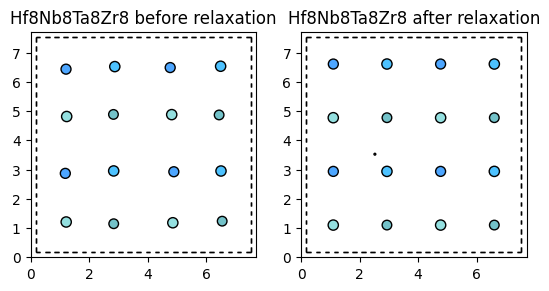

In [239]:
from ase import Atom, Atoms
from ase.constraints import FixAtoms
from ase.io.espresso import read_espresso_in, read_espresso_out, write_espresso_in
from ase.visualize import view
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import nglview
import os

with open(os.environ['OUTPUT_FILENAME'], 'r') as f:
    generator = read_espresso_out(f, index=slice(None))
    atoms = [g for g in generator]
    print(len(atoms))
    atoms = atoms[-1]

# Center slab in vacuum so there's space for a gas to interact
atoms.center(vacuum=6.0, axis=2)
mask = [atom for atom in atoms]
fixatoms = FixAtoms(mask=mask)
atoms.set_constraint(fixatoms)

# Add unconstrained 2H
DEUTERIUM_MASS_AMU = 2.014
deuterium = Atom('H', mass=DEUTERIUM_MASS_AMU, position=(5., 4., 9.0)) # 12.8
atoms.append(deuterium)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2)
with open(os.environ['INPUT_FILENAME'], 'r') as f:
    orig = read_espresso_in(f)
    orig.rattle(stdev=0.05)
plot_atoms(orig, ax1, radii=0.1, rotation=('0x,0y,180z'))
ax1.set_title('Hf8Nb8Ta8Zr8 before relaxation')

plot_atoms(atoms, ax2, radii=0.1, rotation=('0x,0y,180z'))
ax2.set_title('Hf8Nb8Ta8Zr8 after relaxation')

view(atoms, viewer='x3d')

In [149]:
from ase.units import Rydberg

# 1 picosecond = n Rydberg a.u.
ps_to_au = 1e-12 / (4.8378 * 1e-17)
ps_to_au

# 1 femtosecond
fs_to_au = 1e-15 / (4.8378 * 1e-17)

In [150]:
import math

def velocity(atomic_mass, energy):
  """
  Computes the velocity of an atom in Hartree atomic units, given the atomic mass in atomic units and the energy in electronvolts.

  Args:
    atomic_mass: The atomic mass of the atom in atomic units.
    energy: The energy of the atom in electronvolts.

  Returns:
    The velocity of the atom in Hartree atomic units.
  """

  # Convert the atomic mass to kilograms.
  atomic_mass_kg = atomic_mass * 1.660539040e-27

  # Convert the energy to joules.
  energy_joules = energy * 1.60217662e-19

  # Calculate the velocity.
  velocity_ms = math.sqrt((2 * energy_joules) / atomic_mass_kg)

  # Convert the velocity to Hartree atomic units.
  velocity_ha = velocity_ms / 2.187691e6

  return velocity_ha

H_ATOMIC_MASS = 1.00784
assert math.isclose(velocity(H_ATOMIC_MASS, 40), 0.0400031, abs_tol=1e-6)

In [190]:
import os
from ase.io.espresso import write_espresso_in

n_steps = 20
n_atoms = len(atoms) - 1 # subract the single deuterium atom

# Redefine env vars for new pw.x run
os.environ['INPUT_FILENAME'] = f'HfNbTaZr_lattice_{n_atoms}_MD_nsteps_{n_steps}.in'
os.environ['OUTPUT_FILENAME'] = f'HfNbTaZr_lattice_{n_atoms}_MD_nsteps_{n_steps}.out'

# Manually add atomic velocities str
atomic_velocities_str = 'ATOMIC_VELOCITIES\n'
for _ in range(4):
    for el in ['Hf', 'Nb', 'Ta', 'Zr']:
        atomic_velocities_str += f'{el} 0.0 0.0 0.0\n'

DEUTERIUM_MASS_AMU = 2.014
atomic_velocities_str += 'H 0.0 0.0 {:.5f}'.format(-velocity(DEUTERIUM_MASS_AMU, 30)) # H_ATOMIC_MASS

pseudopotentials = {
    'Ta': 'ta_pbe_v1.uspp.F.UPF',
    'Hf': 'hf_pbe_v1.uspp.F.UPF',
    'Nb': 'nb_pbe_v1.uspp.F.UPF',
    'Zr': 'zr_pbe_v1.uspp.F.UPF',
    'H': 'h_pbe_v1.4.uspp.F.UPF',
}
input_data = {
    'control': {
        'calculation': 'md',
        'dt': 0.5 * round(fs_to_au),
        'nstep': n_steps,
        'pseudo_dir': 'q-e/pseudo/',
        'etot_conv_thr': 1e-1, #1e-5,
        'forc_conv_thr': 1e-1 #1e-4
    },
    'electrons': {
        'conv_thr': 1e-3, # 1e-8
        'mixing_mode': 'TF',
        'mixing_beta': 0.7
    },
    'system': {
        'ecutwfc': 120,
        'occupations': 'smearing', # Need smearing params to avoid `Error in routine electrons (1): charge is wrong: smearing is needed`
        'smearing': 'gaussian',
        'degauss': 0.022,
        'nspin': 2
    },
    'ions': {
        'ion_temperature': 'initial',
        'tempw': 300,
        'ion_velocities': 'from_input'
    }
}

k = None
tstress, tprnfor = False, False # True, True
with open(os.environ['INPUT_FILENAME'], 'w') as f:
    write_espresso_in(f, atoms, input_data=input_data, pseudopotentials=pseudopotentials, tstress=tstress, tprnfor=tprnfor, kpts=(k, k, k) if k else None)
    f.write(atomic_velocities_str)

In [ ]:
!mpirun -np 12 q-e/bin/pw.x -inp $INPUT_FILENAME > $OUTPUT_FILENAME

## Visualizing `nstep=20` trajectory

In [233]:
from ase.io.trajectory import TrajectoryWriter

writer = TrajectoryWriter(os.environ['OUTPUT_FILENAME'] + '.traj')
with open('HfNbTaZr_lattice_16_MD_nsteps_20.modified', 'r') as f:
    generator = read_espresso_out(f, index=slice(None))
    for atoms in generator:
        writer.write(atoms)

From here, run `ase gui <filename>.traj`